# Analyze emerging SARS-CoV-2 Lineages based on Mentioning in the Literature
[Work in progress]

This notebook queries the Knowledge Graph for publication and preprints that mention [PANGO lineages](https://cov-lineages.org/). PANGO lineages where text-mined from titles and abstracts of papers in the CORD-19 data set.

References:
Rambaut A, et al., A dynamic nomenclature proposal for SARS-CoV-2 lineages to assist genomic epidemiology(2020) Nature Microbiology [doi:10.1038/s41564-020-0770-5](https://doi.org/10.1038/s41564-020-0770-5).

Lucy Lu Wang, et al., CORD-19: The COVID-19 Open Research Dataset (2020) [arXiv:2004.10706v4](https://arxiv.org/abs/2004.10706).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from py2neo import Graph

In [2]:
# set Pandas options
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns
pd.set_option('display.max_colwidth', 255)
def make_clickable(url):
    url = url.split(';')[0]
    return f'<a href="{url}">{url}</a>'

##### Connect to COVID-19-Community Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

## Get publications and preprints that mention PANGO lineages

In [4]:
top = 15 # number of top lineages for visualization
start_date = '2020-06-01'
end_date = '2021-04-01'

In [5]:
query = """
MATCH (p:Publication)-[:MENTIONS]->(l:Lineage)
WHERE date($start_date) <= p.date <= date($end_date)
RETURN l.name as lineage, count(p) as count, p.date as date
ORDER by count DESC
"""
lineages = graph.run(query, start_date=start_date, end_date=end_date).to_data_frame()

In [6]:
# convert neotime date object to datetime object
lineages['date'] = lineages['date'].astype(str) 
lineages['date'] = pd.to_datetime(lineages['date'])  

## Find the top lineages

In [7]:
top_lineages = lineages.groupby('lineage').size().reset_index(name='count')
top_lineages.sort_values(['count'], inplace=True, ascending=False)
top_lineages = top_lineages.head(top)
legend = top_lineages['lineage'].values
legend = np.append(legend, 'other')
print(f'Top {top} lineages:', legend)

Top 15 lineages: ['B.1.1.7' 'B.1.351' 'P.1' 'B.1' 'B.1.1' 'B.1.1.28' 'B.1.1.33' 'B.1.429'
 'P.2' 'B.6' 'B.1.36' 'B.1.427' 'B.1.177' 'B.4' 'B.1.526' 'other']


Assign all other lineages to an **other** category.

In [8]:
lineages['lineage'] = lineages['lineage'].apply(lambda x: x if x in legend else 'other')

## Distribution of papers by lineage and publication date

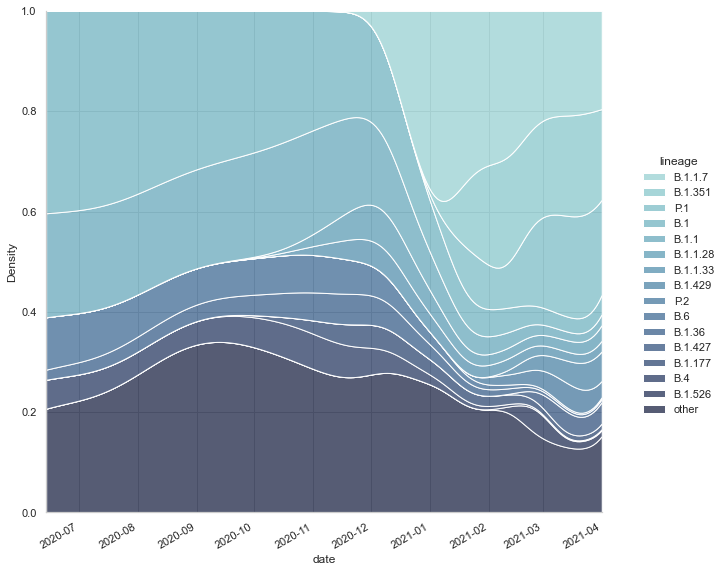

In [9]:
sns.set_theme(style="whitegrid")
sns.displot(lineages, x="date", hue="lineage", hue_order=legend, kind="kde",
            height=9, multiple="fill", cut=0, palette="ch:rot=-.25,hue=1,light=.75").fig.autofmt_xdate();

## Cummulative distribution of papers by lineage and publication date

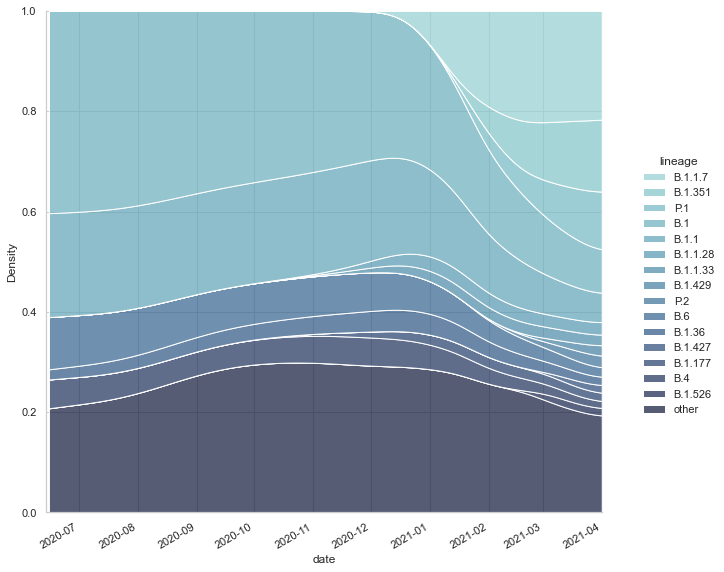

In [10]:
sns.displot(lineages, x="date", hue="lineage", hue_order=legend, kind="kde", cumulative=True,
            height=9, multiple="fill", cut=0, palette="ch:rot=-.25,hue=1,light=.75").fig.autofmt_xdate();

## Get list of papers for a selected lineage

In [11]:
style = {'description_width': 'initial'}
pub_widget = widgets.Dropdown(options=legend[:top], description='Select a lineage:', value='B.1.1.7', style=style)

In [17]:
display(pub_widget)

Dropdown(description='Select a lineage:', index=1, options=('B.1.1.7', 'B.1.351', 'P.1', 'B.1', 'B.1.1', 'B.1.…

In [18]:
lineage = pub_widget.value
print('Lineage selected :', lineage)

Lineage selected : B.1.351


In [19]:
query = """
MATCH (p:Publication)-[:MENTIONS]->(l:Lineage{name:$lineage})
WHERE date($start_date) <= p.date <= date($end_date)
RETURN l.name as lineage, p.date as date, p.title as title, p.journal as journal, p.url as url
ORDER by date DESC
"""
papers = graph.run(query, start_date=start_date, end_date=end_date, lineage=lineage).to_data_frame()

In [20]:
print(f"Number of papers with lineage {lineage}:", papers.shape[0])

Number of papers with lineage B.1.351: 114


In [21]:
papers.style.format({'url': make_clickable})

,lineage,date,title,journal,url
0,B.1.351,2021-04-01,Ultrapotent bispecific antibodies neutralize emerging SARS-CoV-2 variants,bioRxiv,https://doi.org/10.1101/2021.04.01.437942
1,B.1.351,2021-04-01,Linked transmission chains of imported SARS-CoV-2 variant B.1.351 across mainland France January 2021,Euro Surveill,https://www.ncbi.nlm.nih.gov/pubmed/33797392/
2,B.1.351,2021-03-31,A time series forecasting of the proportion of SARS-CoV-2 N501Y lineage in North America,None,https://doi.org/10.1101/2021.03.30.21254648
3,B.1.351,2021-03-31,Improved performance of saliva for the detection of the B.1.351 variant in South Africa,None,https://doi.org/10.1101/2021.03.29.21254563
4,B.1.351,2021-03-30,Sequence analysis of SARS-CoV-2 in nasopharyngeal samples from patients with COVID-19 illustrates population variation and diverse phenotypes placing the in vitro growth properties of B.1.1.7 and B.1.351 lineage viruses in context,bioRxiv,https://doi.org/10.1101/2021.03.30.437704
5,B.1.351,2021-03-30,Antibody evasion by the P.1 strain of SARS-CoV-2,Cell,https://www.ncbi.nlm.nih.gov/pubmed/33852911/
6,B.1.351,2021-03-30,The first SARS-CoV-2 genetic variants of concern VOC in Poland: The concept of a comprehensive approach to monitoring and surveillance of emerging variants.,Advances in medical sciences,https://doi.org/10.1016/j.advms.2021.03.005
7,B.1.351,2021-03-30,Rapid Detection of SARS-CoV-2 Variants of Concern Including B.1.1.28 P.1 in British Columbia Canada.,Emerging infectious diseases,https://doi.org/10.3201/eid2706.210532
8,B.1.351,2021-03-29,A Novel Diagnostic Test to Screen SARS-CoV-2 Variants Containing E484K and N501Y Mutations,None,https://doi.org/10.1101/2021.03.26.21253712
9,B.1.351,2021-03-29,SARS-CoV-2 escape mutants and protective immunity from natural infections or immunizations,Clin Microbiol Infect,https://www.sciencedirect.com/science/article/pii/S1198743X21001464?v=s5
